This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Comparaison of transformation methods

In [1]:
import time

import matplotlib.pyplot as plt
import wradlib
import xarray
import xradar

Get a radar sweep with reflectivity measurements and metadata

In [2]:
from wradlib_data import DATASETS
filename = "hdf5/71_20181220_060628.pvol.h5"
filename = DATASETS.fetch(filename)
volume = xradar.io.open_odim_datatree(filename)
sweep = volume['sweep_0'].ds
metadata = xradar.model.required_sweep_metadata_vars
sweep = sweep[["DBZH"] + list(metadata)]

Interpolate radar sweep into a Cartesian grid using nearest neighbor method

In [3]:
window = [-200E3, 200E3, -200E3, 200E3]
size = 1000
lon = float(sweep.longitude.values)
lat = float(sweep.latitude.values)
crs = wradlib.georef.get_radar_projection((lon, lat))
raster = wradlib.georef.create_raster_xarray(crs, window, size)
grid = raster
sweep = sweep.wrl.georef.georeference(crs=crs)
tic = time.time()
comp1 = sweep.DBZH.wrl.comp.togrid(grid, radius=250E3, center=(lon,lat), interpol=wradlib.ipol.Nearest)
toc = time.time() - tic
print(f"Time elapsed: {toc}")

Time elapsed: 0.46278858184814453


Combine radar sweep into a raster image by taking the mean

In [4]:
tic = time.time()
transform = wradlib.comp.transform_binned(sweep, raster)
comp2 = wradlib.comp.sweep_to_raster(sweep, raster)
toc = time.time() - tic
print(f"Time elapsed: {toc}")

C:\Users\egoud\.venvs\wradlib\Lib\site-packages\scipy\stats\_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))


Time elapsed: 7.027102947235107


Compare the methods at close range

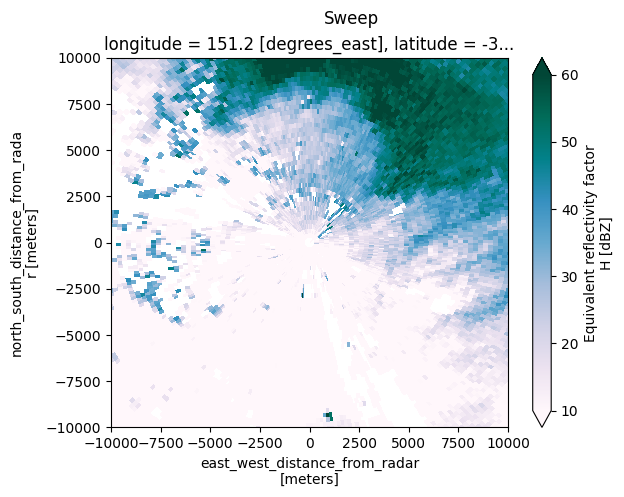

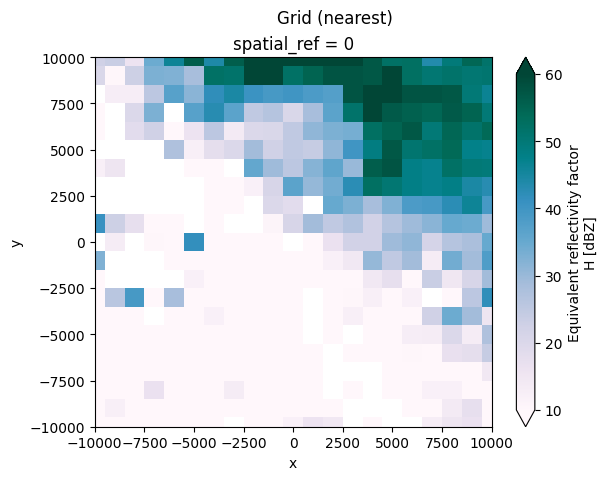

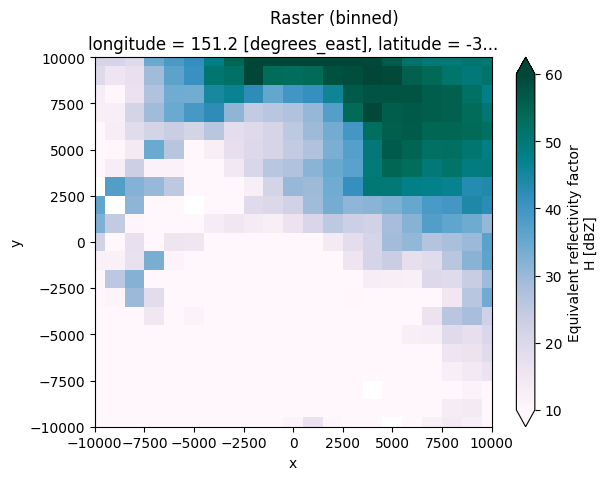

In [5]:
sweep.DBZH.plot(x='x', y='y', cmap="PuBuGn", vmin=10, vmax=60)
plt.xlim(-10E3,10E3)
plt.ylim(-10E3,10E3)
plt.suptitle("Sweep")
plt.show()

comp1.plot.pcolormesh(cmap="PuBuGn", vmin=10, vmax=60)
plt.xlim(-10E3,10E3)
plt.ylim(-10E3,10E3)
plt.suptitle("Grid (nearest)")
plt.show()

comp2 = comp2.drop_vars("spatial_ref")
comp2["DBZH"].plot.pcolormesh(cmap="PuBuGn", vmin=10, vmax=60)
plt.xlim(-10E3,10E3)
plt.ylim(-10E3,10E3)
plt.suptitle("Raster (binned)")
plt.show()